<a href="https://colab.research.google.com/github/karam-koujan/Transformer/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = get_device()
class Positional_embedding(nn.Module):
      def __init__(self,d_model,max_len) :
            super(Positional_embedding,self).__init__()
            self.d_model = d_model
            self.max_len = max_len
            self.positional_embedding = torch.zeros((max_len,d_model)).to(device)
            pos = torch.arange(0,max_len,dtype=torch.float).unsqueeze(1)
            div = torch.pow(1000,torch.arange(0,d_model,2,dtype=torch.float)/d_model)
            self.positional_embedding[:,0::2] = torch.sin(pos/div)
            self.positional_embedding[:,1::2] = torch.cos(pos/div)
      def forward(self,x) :
            print("============ positional embedding ==========",x.size(),self.positional_embedding.size())
            x = x +  self.positional_embedding
            return x
class Tokenizer(nn.Module) :
      def __init__(self,model_d,max_sequence_length,language_to_index,start_token,end_token,pad_token,dropout_p=0.1) :
            super(Tokenizer,self).__init__()
            self.vocab_size = len(language_to_index) + 3
            self.embedding = nn.Embedding(self.vocab_size,model_d)
            self.max_sequence_length = max_sequence_length
            self.language_to_index = language_to_index
            self.start_token = start_token
            self.end_token = end_token
            self.pad_token = pad_token
            self.dropout = nn.Dropout(p=dropout_p)
            self.positional_embedding = Positional_embedding(model_d,max_sequence_length)
      def batch_tokenization(self,batch,start_token,end_token) :
              def sentence_tokenize(sentence,start_token,end_token) :
                      sentence_to_index = []
                      for tokenIdx,token in enumerate(list(sentence)) :
                              if tokenIdx + int(start_token) + int(end_token) + 1 >= self.max_sequence_length :
                                          break
                              if token in self.language_to_index:
                                      sentence_to_index.append(self.language_to_index[token] )
                              else :
                                      sentence_to_index.append(self.language_to_index['<unk>'])
                      if start_token :
                            sentence_to_index.insert(0,self.language_to_index[self.start_token])
                      if end_token :
                            sentence_to_index.append(self.language_to_index[self.end_token])

                      for _ in range(len(sentence_to_index),self.max_sequence_length):
                                  sentence_to_index.append(self.language_to_index[self.pad_token])
                      return torch.tensor(sentence_to_index).to(device)

              sentence_batch = []
              for sentence_idx in range(len(batch)) :
                    sentence_batch.append(sentence_tokenize(batch[sentence_idx],start_token,end_token))

              sentence_batch = torch.stack(sentence_batch)
              return sentence_batch.to(device)
      def forward(self,x,start_token,end_token) :
            # (batch,vocab_size,embed_d)
            print("============== Tokenization ===============")
            x = self.batch_tokenization(x,start_token,end_token)
            x = self.embedding(x)
            pos = self.positional_embedding(x)
            x = self.dropout(x+pos)
            return x





In [2]:
class LayerNorm(nn.Module):
      def __init__(self,epsilon=1e-6):
              super(LayerNorm,self).__init__()
              self.epsilon = epsilon

      def forward(self,x) :
              print("============== LayerNormalization ===============", x.size())
              batch_size,seq_length,model_d = x.shape
              gamma = nn.Parameter(torch.ones(model_d).to(device))
              beta = nn.Parameter(torch.zeros(model_d).to(device))
              mean = x.mean(-1,keepdim=True)
              var = x.var(-1,keepdim=True)
              x_normalized = (x - mean) / torch.sqrt(var + self.epsilon)

              x = gamma * x_normalized + beta
              return x

In [3]:
class MultiHeadAttention(nn.Module) :
      def __init__(self,input_d,model_d,heads_num) :
                  super(MultiHeadAttention,self).__init__()
                  self.input_d = input_d
                  self.model_d = model_d
                  self.heads_num = heads_num
                  self.qkv_d = model_d // heads_num
                  self.queryP = nn.Linear(model_d,model_d)
                  self.valueP = nn.Linear(model_d,model_d)
                  self.keyP = nn.Linear(model_d,model_d)
                  self.out = nn.Linear(model_d,model_d)
      def attention(self,q,k,v,mask=None) :
             dk = torch.tensor(k.shape[-1],dtype=torch.float32)
             energy = torch.matmul(q,k.transpose(-2,-1)) / torch.sqrt(dk)
             if False :
                        mask = mask.unsqueeze(1).unsqueeze(3)
                        energy =  energy.masked_fill(mask != 0, float('-1e9'))
             return torch.matmul(torch.softmax(energy,dim=-1),v)
      def forward(self,x,mask=None):
              """
               first we create key,query and value using a linear projection using a 1 fully connected layer
               The size of these tensors is (input_sequence_length,model_d)
              """
              print("============== MultiHeadAttention ===============")
              query= None
              key = None
              value = None
              batch_size = None
              if isinstance(x,(list,tuple)) :
                   query,key,value = x
                   batch_size = query.size(0)
                   query = self.queryP(query)
                   key = self.keyP(key)
                   value = self.valueP(value)

              else :
                   batch_size = x.size(0)
                   query = self.queryP(x)
                   key = self.keyP(x)
                   value = self.valueP(x)

              """
               we add another dimension for heads now the tensors size is (heads_num,input_sequence,model_d)
               calculte attention for each head independently and in parallel
              """
              query = query.view(batch_size,self.heads_num,self.input_d,self.qkv_d)
              key = key.view(batch_size, self.heads_num,self.input_d, self.qkv_d)
              value = value.view(batch_size, self.heads_num,self.input_d, self.qkv_d)
              attention = self.attention(query, key, value, mask)
              attention = attention.view(batch_size, self.input_d, self.model_d)
              out = self.out(attention)
              return out



In [4]:
import torch.nn.functional as F
class FeedForward(nn.Module) :
        def __init__(self,input_size,output_size,hidden_size,dropout_p=0.1) :
                  super(FeedForward,self).__init__()
                  self.fc1 =  nn.Linear(input_size,hidden_size)
                  self.fc2 = nn.Linear(hidden_size,output_size)
                  self.dropout = nn.Dropout(p=dropout_p)
        def forward(self,x) :
                  print("============== FeedForward NN  ===============", x.size())
                  x = F.relu(self.fc1(x))
                  x = self.dropout(x)
                  x = self.fc2(x)
                  return x

In [5]:
class EncoderLayer(nn.Module) :
     def __init__(self,model_d,dropout_p,vocab_size,max_length,hidden_size=2048,attention_heads=8) :
        super(EncoderLayer,self).__init__()
        self.model_d = model_d
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.attention_heads = attention_heads
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.multi_head_attention =  MultiHeadAttention(self.max_length,self.model_d,self.attention_heads)
        self.layernorm = LayerNorm()
        self.fc = FeedForward(self.model_d,self.model_d,self.hidden_size)

     def forward(self,x,mask=None) :
              res_x = x.clone()
              x = self.multi_head_attention(x,mask)
              x = self.dropout1(x)
              x = self.layernorm(x + res_x )
              res_x = x.clone()
              x = self.fc(x)
              x = self.dropout2(x)
              x =  self.layernorm(x + res_x )
              return x


In [6]:
class EncoderLayers(nn.Sequential) :

          def forward(self, x,mask=None):
                     for module in self._modules.values():
                          x = module(x,mask)
                     return x

In [7]:
class Encoder(nn.Module):
           def __init__(self,model_d,dropout_p,num_layers,language_to_index,start_token,end_token,pad_token,vocab_size,max_length,hidden_size=2048,attention_heads=8) :
                super(Encoder,self).__init__()
                self.layers  = EncoderLayers(*[ EncoderLayer(model_d,dropout_p,vocab_size,max_length,hidden_size,attention_heads) for _ in range(num_layers)])
                self.tokenizer = Tokenizer(model_d,max_sequence_length,language_to_index,start_token,end_token,pad_token)
           def forward(self,x,mask,start_token,end_token) :
                   x = self.tokenizer(x,start_token,end_token)
                   x = self.layers(x,mask)
                   return x



In [8]:
class DecoderLayer(nn.Module) :
        def __init__(self,model_d,dropout_p,vocab_size,max_length,hidden_size=2048,attention_heads=8) :
            super(DecoderLayer,self).__init__()
            self.model_d = model_d
            self.max_length = max_length
            self.hidden_size = hidden_size
            self.vocab_size = vocab_size
            self.attention_heads = attention_heads
            self.dropout1 = nn.Dropout(p=dropout_p)
            self.dropout2 = nn.Dropout(p=dropout_p)
            self.dropout3 = nn.Dropout(p=dropout_p)
            self.multi_head_attention =  MultiHeadAttention(self.max_length,self.model_d,self.attention_heads)
            self.layernorm = LayerNorm()
            self.fc = FeedForward(self.model_d,self.model_d,self.hidden_size)
        def forward(self,x,encoder_out,att_mask,pad_mask) :
                    res_x = x.clone()
                    x = self.multi_head_attention(x,att_mask)
                    x = self.dropout1(x)
                    x = self.layernorm(x + res_x )
                    res_x = x.clone()
                    x  = self.multi_head_attention((x,encoder_out,encoder_out),pad_mask)
                    x = self.dropout2(x)
                    x = self.layernorm(x + res_x )
                    res_x = x.clone()
                    x =  self.fc(x)
                    x = self.dropout3(x)
                    x = self.layernorm(x + res_x )
                    return x


In [9]:
class DecoderLayers(nn.Sequential) :

          def forward(self, x, encoder_out,att_mask,pad_mask):
                     for module in self._modules.values():
                          x = module(x,encoder_out,att_mask,pad_mask)
                     return x

In [10]:
class Decoder(nn.Module):
           def __init__(self,model_d,dropout_p,num_layers,language_to_index,start_token,end_token,pad_token,vocab_size,max_length,hidden_size=2048,attention_heads=8) :
                super(Decoder,self).__init__()
                self.layers  = DecoderLayers(*[ DecoderLayer(model_d,dropout_p,vocab_size,max_length,hidden_size,attention_heads) for _ in range(num_layers)])
                self.tokenizer = Tokenizer(model_d,max_sequence_length,language_to_index,start_token,end_token,pad_token)

           def forward(self,x,encoder_out,att_mask,pad_mask,start_token,end_token) :
                   x = self.tokenizer(x,start_token,end_token)
                   x = self.layers(x,encoder_out,att_mask,pad_mask)
                   return  x



In [11]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5



In [12]:
class Transformer(nn.Module):
    def __init__(self,model_d,dropout_p,
                num_layers,
                english_to_index,
                german_to_index,
                start_token,
                end_token,
                pad_token
                ,vocab_size,max_length,hidden_size=2048,attention_heads=8
                ):
        super().__init__()
        self.encoder = Encoder(model_d,dropout_p,num_layers,english_to_index,start_token,end_token,pad_token,vocab_size,max_length)
        self.decoder = Decoder(model_d,dropout_p,num_layers,german_to_index,start_token,end_token,pad_token,vocab_size,max_length)
        self.linear = nn.Linear(d_model, vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self,
                x,
                y,
                encoder_pad_mask=None,
                decoder_att_mask=None,
                decoder_pad_mask=None,
                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False, # We should make this true
                dec_end_token=False): # x, y are batch of sentences
        x = self.encoder(x,encoder_pad_mask ,start_token=enc_start_token, end_token=enc_end_token)
        out = self.decoder(y,x,decoder_att_mask,decoder_pad_mask, start_token=dec_start_token, end_token=dec_end_token)
        out = self.linear(out)
        return out

In [13]:
import numpy as np


file_path = "./deu.txt"
start_token = '<start>'
end_token = '<end>'
pad_token = '<pad>'
english_vocabulary = [start_token,'<unk>', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/','`','’',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      ':', '<', '=', '>', '?', '@','[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~', pad_token, end_token]

german_vocabulary = [start_token,'<unk>',' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/','`','’',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      ':', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`',
                      'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                      'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                      'y', 'z', 'ä', 'ö', 'ü', 'ß',
                      '{', '|', '}', '~', pad_token, end_token]


In [14]:
index_to_german = {k : v  for k,v in enumerate(german_vocabulary)}
german_to_index = {v : k  for k,v in enumerate(german_vocabulary)}
index_to_english = {k : v  for k,v in enumerate(english_vocabulary)}
english_to_index = {v : k  for k,v in enumerate(english_vocabulary)}

In [15]:

with open(file_path, 'r') as file:
    raw_data = file.readlines()

In [16]:
sentences =  [ (sentence.rstrip("\n").split("\t")[0].lower(),sentence.rstrip("\n").split("\t")[1].lower()) for sentence in raw_data]
sentences

[('go.', 'geh.'),
 ('hi.', 'hallo!'),
 ('hi.', 'grüß gott!'),
 ('run!', 'lauf!'),
 ('run.', 'lauf!'),
 ('wow!', 'potzdonner!'),
 ('wow!', 'donnerwetter!'),
 ('fire!', 'feuer!'),
 ('help!', 'hilfe!'),
 ('help!', 'zu hülf!'),
 ('stop!', 'stopp!'),
 ('wait!', 'warte!'),
 ('wait.', 'warte.'),
 ('begin.', 'fang an.'),
 ('go on.', 'mach weiter.'),
 ('hello!', 'hallo!'),
 ('hurry!', 'beeil dich!'),
 ('hurry!', 'schnell!'),
 ('i hid.', 'ich versteckte mich.'),
 ('i hid.', 'ich habe mich versteckt.'),
 ('i ran.', 'ich rannte.'),
 ('i see.', 'ich verstehe.'),
 ('i see.', 'aha.'),
 ('i try.', 'ich probiere es.'),
 ('i won!', 'ich hab gewonnen!'),
 ('i won!', 'ich habe gewonnen!'),
 ('relax.', 'entspann dich.'),
 ('shoot!', 'feuer!'),
 ('shoot!', 'schieß!'),
 ('smile.', 'lächeln!'),
 ('ask me.', 'frag mich!'),
 ('ask me.', 'fragt mich!'),
 ('ask me.', 'fragen sie mich!'),
 ('attack!', 'angriff!'),
 ('attack!', 'attacke!'),
 ('cheers!', 'zum wohl!'),
 ('eat it.', 'iss es.'),
 ('eat up.', 'iss auf.'

In [17]:
import numpy as np
PERCENTILE = 97
print( f"{PERCENTILE}th percentile length English: {np.percentile([len(x[0]) for x in sentences], PERCENTILE)}" )
print( f"{PERCENTILE}th percentile length German: {np.percentile([len(x[1]) for x in sentences], PERCENTILE)}" )



97th percentile length English: 17.0
97th percentile length German: 30.0


In [18]:
max_sequence_length = 80
def is_token_exist(sentence,vocab):
     for token in sentence :
           if token not in vocab :
                 return False
     return True

def  is_valid_length(sentence,max_sequence_length) :
           return len(sentence) < max_sequence_length - 1

is_token_exist('sie geht zu fuß.',german_vocabulary)


True

In [19]:
valid_sentence_indicies = []
for index in range(len(sentences)):
    german_sentence, english_sentence = sentences[index][1], sentences[index][0]
    if is_valid_length(german_sentence, max_sequence_length) \
      and is_valid_length(english_sentence, max_sequence_length) \
      and is_token_exist(german_sentence, german_vocabulary):
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of sentences: 17605
Number of valid sentences: 17586


In [20]:
d_model = 512
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 1
max_sequence_length = 200
german_vocab_size = len(german_vocabulary)
transformer = Transformer(d_model,drop_prob,num_layers,english_to_index,german_to_index,start_token,end_token,pad_token,vocab_size=german_vocab_size,max_length=max_sequence_length)
len(english_to_index)

73

In [21]:
from torch.utils.data import DataLoader,Dataset
class TextDataset(Dataset) :
    def __init__(self,sentences) :
         self.sentences = sentences


    def __len__(self) :
         return len(self.sentences)
    def __getitem__(self,idx):
           german = self.sentences[idx][1]
           english = self.sentences[idx][0]
           return english,german


In [22]:
dataset = TextDataset(sentences)

In [23]:
print(dataset[3],len(dataset))

('run!', 'lauf!') 17605


In [24]:
criterian = nn.CrossEntropyLoss(ignore_index=german_to_index[pad_token],reduction="none")
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)
optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)


In [25]:
import numpy as np

def create_masks(eng_batch, ger_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.zeros((max_sequence_length, max_sequence_length))
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.zeros((num_sentences, max_sequence_length, max_sequence_length))
    decoder_padding_mask_self_attention = torch.zeros((num_sentences, max_sequence_length, max_sequence_length))
    decoder_padding_mask_cross_attention = torch.zeros((num_sentences, max_sequence_length, max_sequence_length))

    for idx in range(num_sentences):
      eng_sentence_length, ger_sentence_length = len(eng_batch[idx]), len(ger_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length  , max_sequence_length)
      ger_chars_to_padding_mask = np.arange(ger_sentence_length , max_sequence_length)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = 1
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = 1
      decoder_padding_mask_self_attention[idx, :, ger_chars_to_padding_mask] = 1
      decoder_padding_mask_self_attention[idx, ger_chars_to_padding_mask, :] = 1
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = 1
      decoder_padding_mask_cross_attention[idx, ger_chars_to_padding_mask, :] = 1
    decoder_self_attention_mask =   decoder_padding_mask_self_attention + look_ahead_mask
    return encoder_padding_mask, decoder_self_attention_mask, decoder_padding_mask_cross_attention,

In [26]:
train_loader = DataLoader(dataset,batch_size)

In [30]:
transformer.train()
transformer.to(device)
num_epochs = 11
losses  = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    epoch_loss = 0.0

    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, ger_batch = batch

        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, ger_batch)
        optim.zero_grad()
        ger_predictions = transformer(eng_batch,
                                     ger_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)
        labels = transformer.decoder.tokenizer.batch_tokenization(ger_batch, start_token=False, end_token=True)
        loss = criterian(
            ger_predictions.view(-1, german_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == german_to_index[pad_token], False, True)
        loss = loss.sum() / valid_indicies.sum()
        epoch_loss+=loss.item()
        loss.backward()
        optim.step()
        torch.save(ger_predictions, 'transformer_weights.pth')


    losses.append(epoch_loss/len(iterator))

Streaming output truncated to the last 5000 lines.
============== FeedForward NN  =============== torch.Size([30, 200, 512])
============== LayerNormalization =============== torch.Size([30, 200, 512])
============== Tokenization ===============
============ positional embedding ========== torch.Size([30, 200, 512]) torch.Size([200, 512])
============== MultiHeadAttention ===============
============== LayerNormalization =============== torch.Size([30, 200, 512])
============== FeedForward NN  =============== torch.Size([30, 200, 512])
============== LayerNormalization =============== torch.Size([30, 200, 512])
============== Tokenization ===============
============ positional embedding ========== torch.Size([30, 200, 512]) torch.Size([200, 512])
============== MultiHeadAttention ===============
============== LayerNormalization =============== torch.Size([30, 200, 512])
============== MultiHeadAttention ===============
============== LayerNormalization =============== torch.Size([30,

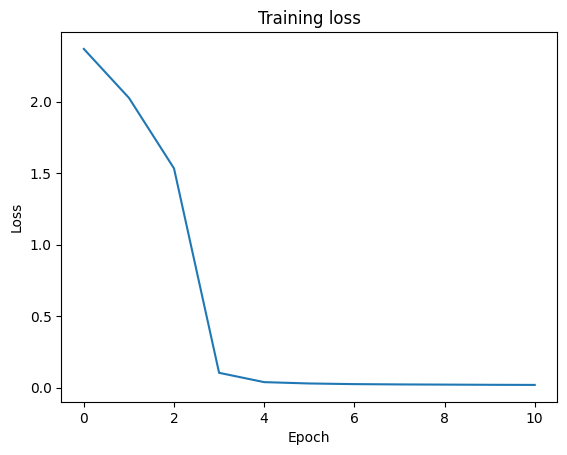

In [31]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training loss")
plt.show()

In [41]:
def translate(eng_sentence) :
     transformer.eval()

     ger_sentence = ("",)
     eng_sentence = (eng_sentence,)
     with torch.no_grad():
        for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, ger_sentence)
                predictions = transformer(eng_sentence,
                                          ger_sentence,
                                          encoder_self_attention_mask.to(device),
                                          decoder_self_attention_mask.to(device),
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=False,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = index_to_german[next_token_index]
                print("next token",next_token)
                ger_sentence = (ger_sentence[0] + next_token, )
                if next_token == end_token:
                  break

     print(f"{eng_sentence} : {ger_sentence}")


In [42]:
translate("hi")

============== Tokenization ===============
============ positional embedding ========== torch.Size([1, 200, 512]) torch.Size([200, 512])
============== MultiHeadAttention ===============
============== LayerNormalization =============== torch.Size([1, 200, 512])
============== FeedForward NN  =============== torch.Size([1, 200, 512])
============== LayerNormalization =============== torch.Size([1, 200, 512])
============== Tokenization ===============
============ positional embedding ========== torch.Size([1, 200, 512]) torch.Size([200, 512])
============== MultiHeadAttention ===============
============== LayerNormalization =============== torch.Size([1, 200, 512])
============== MultiHeadAttention ===============
============== LayerNormalization =============== torch.Size([1, 200, 512])
============== FeedForward NN  =============== torch.Size([1, 200, 512])
============== LayerNormalization =============== torch.Size([1, 200, 512])
next token <end>
('hi',) : ('<end>',)
